In [1]:
%pylab inline
import GPy
import GPyOpt
from numpy.random import beta
from numpy.random import seed
from scipy.special import erf,erfc
from GPyOpt.util.general import get_quantiles
from GPyOpt.experiment_design import initial_design
from GPyOpt.acquisitions.EI_PoF import AcquisitionEI_PoF
from GPyOpt.methods import ModularConstrainedBayesianOptimization

Populating the interactive namespace from numpy and matplotlib


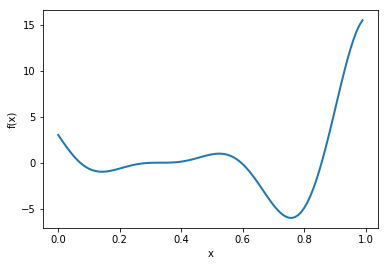

In [2]:
# --- Function to optimize
func = GPyOpt.objective_examples.experiments1d.forrester() 
func.plot()

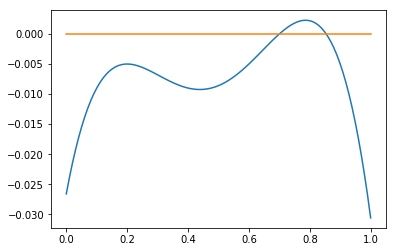

In [3]:
# Desired constraint
x = np.linspace(0,1.0,100)
plt.plot(x,-x*(0.4-x)*(x-0.6)*(0.9-x)+0.04*(x-0.6)*(0.9-x)-0.005)
plt.plot(x,np.zeros(x.shape))

In [4]:
def g(x):
    return (-x*(0.4-x)*(x-0.6)*(0.9-x)+0.04*(x-0.6)*(0.9-x)-0.005)

In [5]:
objective = GPyOpt.core.task.SingleObjective(func.f)

In [6]:
def test_constraint(x):
    return -x*(0.4-x)*(x-0.6)*(0.9-x)-0.0025

In [7]:
constraint = test_constraint

In [8]:
space = [{'name': 'var1', 'type': 'continuous', 'domain': (0,1)}]
space = GPyOpt.Design_space(space = space)

In [9]:
model = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)

In [10]:
model_c = [GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)]

In [11]:
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

In [12]:
acquisition = AcquisitionEI_PoF(model,model_c,space,optimizer=aquisition_optimizer,jitter=0.0,jitter_c=np.array([0]))

In [13]:
# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [14]:
X_init = np.array([[0.0],[0.5],[1.0]])
Y_init = func.f(X_init)

In [15]:
print(X_init)
print(Y_init)

[[0. ]
 [0.5]
 [1. ]]
[[ 3.02720998]
 [ 0.90929743]
 [15.82973195]]


In [16]:
C_init = np.empty(Y_init.shape)
for i in range(X_init.shape[0]):
    print(g(X_init[i]))
    C_init[i,:] = g(X_init[i])

[-0.0266]
[-0.0086]
[-0.0306]


In [17]:
print(C_init)

[[-0.0266]
 [-0.0086]
 [-0.0306]]


In [18]:
iter_count = 20
current_iter = 0
X_step = X_init
Y_step = Y_init
C_step = C_init

In [19]:
print(Y_step)

[[ 3.02720998]
 [ 0.90929743]
 [15.82973195]]


In [20]:
print(type(Y_step),Y_step.dtype,Y_step.shape)
print(type(C_step),C_step.dtype,C_step.shape)

<class 'numpy.ndarray'> float64 (3, 1)
<class 'numpy.ndarray'> float64 (3, 1)


In [21]:
while current_iter < iter_count:
    print("Current iteration - ",current_iter)
    bo_step = ModularConstrainedBayesianOptimization(model, 
                                                     model_c, 
                                                     space, 
                                                     objective, 
                                                     None, 
                                                     acquisition, 
                                                     evaluator, 
                                                     X_init=X_step, 
                                                     Y_init=Y_step, 
                                                     C_init=C_step, 
                                                     normalize_Y = False)
    
    x_next = bo_step.suggest_next_locations()
    y_next = func.f(x_next)
    c_next = g(x_next)
    print(x_next,y_next,c_next)
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    C_step = np.vstack((C_step, c_next))
    
    current_iter += 1

Current iteration -  0
[[0.]] [[3.02720998]] [[-0.0266]]
Current iteration -  1
[[0.33519202]] [[2.77376175e-06]] [[-0.00773359]]
Current iteration -  2
[[0.70870004]] [[-4.96308672]] [[0.00038106]]
Current iteration -  3
[[0.70861448]] [[-4.95974678]] [[0.00037742]]
Current iteration -  4
[[0.73969572]] [[-5.86496786]] [[0.00152268]]
Current iteration -  5
[[0.76176975]] [[-6.00968728]] [[0.00205695]]
Current iteration -  6
[[0.75674902]] [[-6.02060689]] [[0.00196019]]
Current iteration -  7
[[0.18813278]] [[-0.7478464]] [[-0.00504129]]
Current iteration -  8
[[0.75734216]] [[-6.0207354]] [[0.00197244]]
Current iteration -  9
[[0.75671448]] [[-6.02058785]] [[0.00195947]]
Current iteration -  10
[[0.75727309]] [[-6.02073974]] [[0.00197102]]
Current iteration -  11
[[0.75735325]] [[-6.02073422]] [[0.00197266]]
Current iteration -  12
[[0.7580246]] [[-6.02041791]] [[0.00198626]]
Current iteration -  13
[[0.75733031]] [[-6.0207365]] [[0.00197219]]
Current iteration -  14
[[0.75710454]] [[

In [22]:
print(X_step.shape,C_step.shape,C_step.shape)

(23, 1) (23, 1) (23, 1)


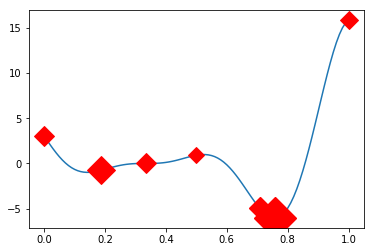

In [23]:
x = np.arange(0.0, 1.0, 0.01)
y = func.f(x)

plt.figure()
plt.plot(x, y)
for i, (xs, ys) in enumerate(zip(X_step, Y_step)):
    plt.plot(xs, ys, 'rD', markersize=10 + 20 * (i+1)/len(X_step))

0.0009709666661800165
3836.557299196572
0.7621718841865053
0.21980360907343677
0.061580990440339045
0.02329802924270746
0.000854649606812167
0.00016723586216250798
8.940895318016354e-11
4.458547643702049e-13
2.2034764538564545e-13
1.0707713670682084e-13
6.398409674807686e-14
1.2040206507916654e-14
1.1686898299417852e-14
1.13612542152709e-14
1.102573940766807e-14
1.1118560082740375e-14
1.1045571909695441e-14
8.596217410541912e-15
8.535025087846418e-15


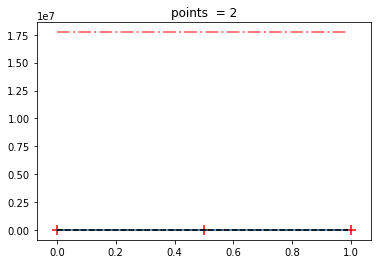

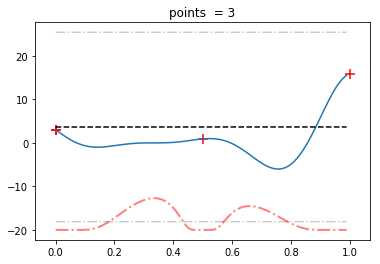

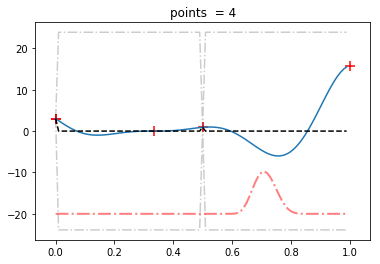

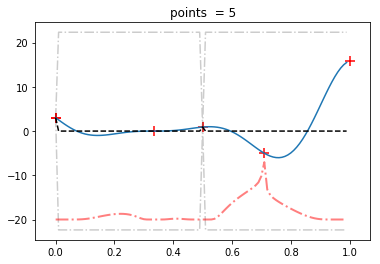

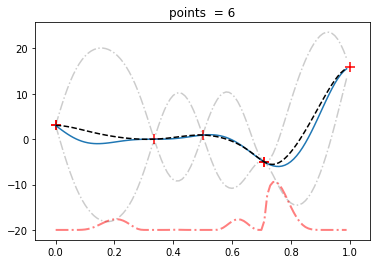

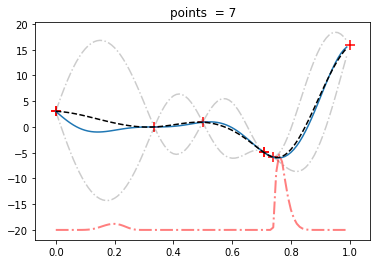

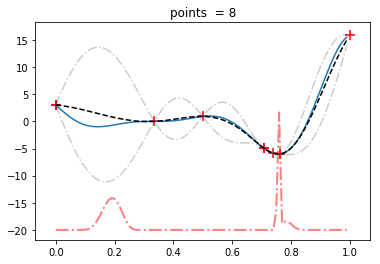

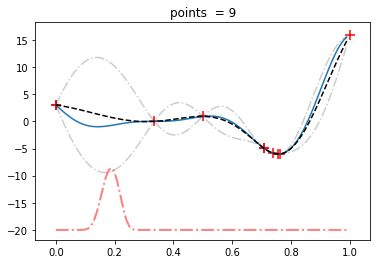

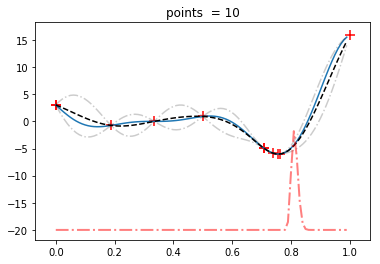

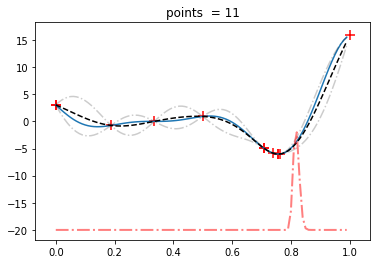

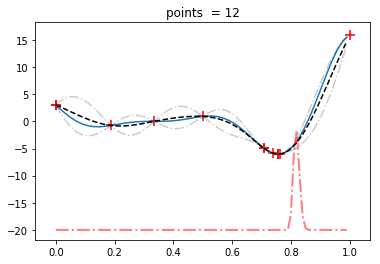

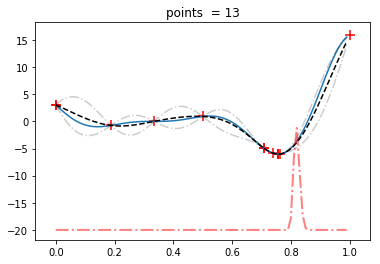

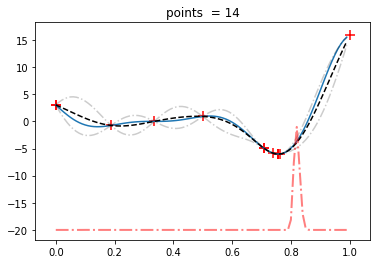

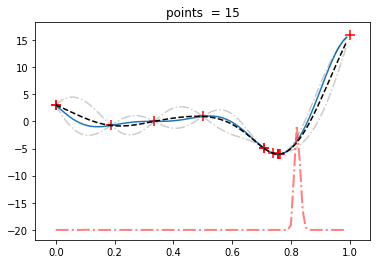

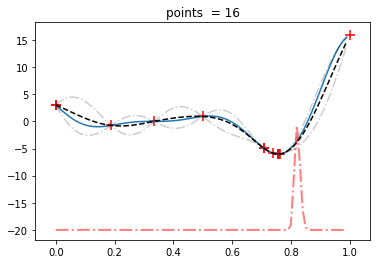

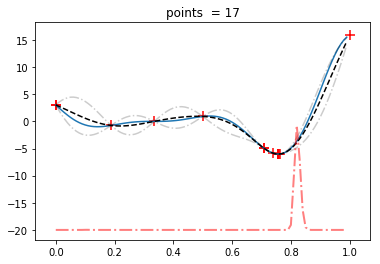

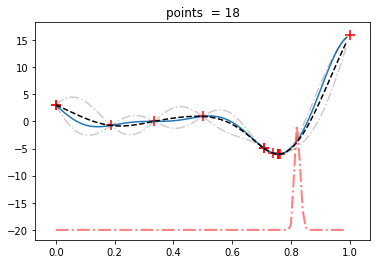

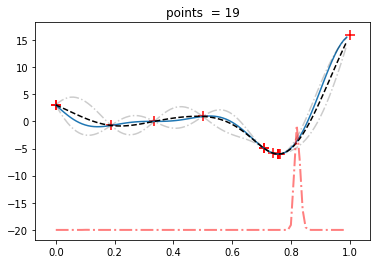

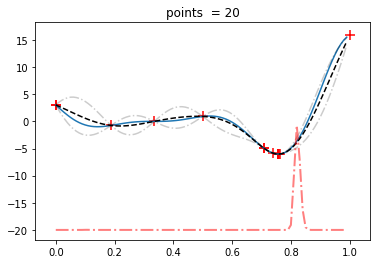

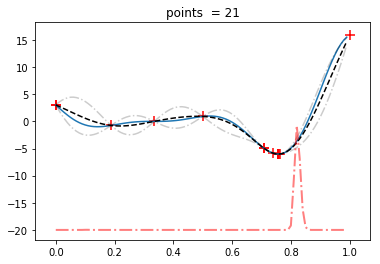

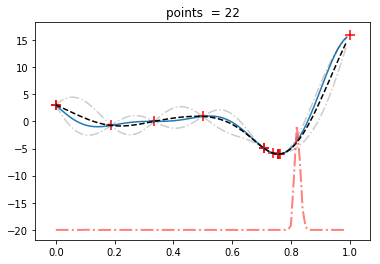

In [30]:
for n in range(3,X_step.shape[0]+1):
    bo_step = ModularConstrainedBayesianOptimization(model, 
                                                     model_c, 
                                                     space, 
                                                     objective, 
                                                     None, 
                                                     acquisition, 
                                                     evaluator, 
                                                     X_init=X_step[0:n,:], 
                                                     Y_init=Y_step[0:n,:], 
                                                     C_init=C_step[0:n,:], 
                                                     normalize_Y = False)
    
    
    model.updateModel(X_step[0:n,:],Y_step[0:n,:],None,None)
    model_c[0].updateModel(X_step[0:n,:],C_step[0:n,:],None,None)
    
    m,v = model.model.predict(x[:,np.newaxis])
    
    acq = bo_step.acquisition.acquisition_function(x[:,np.newaxis])
    
    print(np.std(acq))
    
    fig = plt.figure()
    plt.title("points  = "+str(n-1))
    plt.plot(x, y)
    plt.scatter(X_step[0:n,:],Y_step[0:n,:],marker='+',s=120,c='r')
    
    plt.plot(x,m,'k--')
    plt.plot(x,m-2.96*np.sqrt(v),'k-.', alpha=0.2)
    plt.plot(x,m+2.96*np.sqrt(v),'k-.', alpha=0.2)
        
    plt.plot(x,-2.5*(acq/np.std(acq))-20, 'r-.',lw=2,label ='Acquisition (arbitrary units)',alpha=0.5)